# Alternating Least Squares Using  Spark MLB

In [14]:
!pip install recommenders pyspark pandas seaborn matplotlib scikit-surprise

In [15]:
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, LongType

from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

from surprise import Dataset


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**start Spark Session  and Load Data**

In [16]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

24/10/16 12:39:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [17]:
# Load Dataset using Scikit-Surprise
data = Dataset.load_builtin('ml-1m')


In [18]:
COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"


In [19]:
# Convert the surprise dataset to a Pandas DataFrame
# Extract user-item-rating tuples
trainset = data.build_full_trainset()
ratings = [(trainset.to_raw_uid(uid), trainset.to_raw_iid(iid), rating)
           for uid, iid, rating in trainset.all_ratings()]

# Create a Pandas DataFrame
ratings_df = pd.DataFrame(ratings, columns=[COL_USER, COL_ITEM, COL_RATING])

ratings_df[COL_USER]=ratings_df[COL_USER].astype(int)
ratings_df[COL_ITEM]=ratings_df[COL_ITEM].astype(int)
ratings_df[COL_RATING]=ratings_df[COL_RATING].astype(float)

#  Convert the Pandas DataFrame to a Spark DataFrame
# Initialize SparkSession
spark = SparkSession.builder.appName('MovieLens').getOrCreate()

mySchema = StructType([ StructField(COL_USER, IntegerType()),
                       StructField(COL_ITEM, IntegerType()),
                       StructField(COL_RATING, FloatType())
                       ])
# Convert to Spark DataFrame
spark_df = spark.createDataFrame(ratings_df, mySchema)

# Show the resulting Spark DataFrame
spark_df.show(5)

24/10/16 12:39:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/10/16 12:39:56 WARN TaskSetManager: Stage 311 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


+------+-------+------+
|UserId|MovieId|Rating|
+------+-------+------+
|     1|   1193|   5.0|
|     1|    661|   3.0|
|     1|    914|   3.0|
|     1|   3408|   4.0|
|     1|   2355|   5.0|
+------+-------+------+
only showing top 5 rows



In [20]:
print(f"Dataset size = {spark_df.count()}")

24/10/16 12:39:56 WARN TaskSetManager: Stage 312 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


Dataset size = 1000209


In [21]:

dfs_train, dfs_test = spark_random_split(spark_df, ratio=0.75, seed=42)

In [22]:
print(f"dfs_train size = {dfs_train.count()}")
print(f"dfs_test size = {dfs_test.count()}")

24/10/16 12:39:59 WARN TaskSetManager: Stage 315 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


dfs_train size = 750012


24/10/16 12:40:03 WARN TaskSetManager: Stage 318 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


dfs_test size = 250197


In [23]:
## Train ALS model :

In [24]:
# Config :
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05
K=10

In [25]:
als = ALS(
    maxIter=MAX_ITER,
    rank=RANK,
    regParam=REG_PARAM,
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

24/10/16 12:40:06 WARN TaskSetManager: Stage 321 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:07 WARN TaskSetManager: Stage 322 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


## Evaluation :

In [26]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)

evaluations = SparkRatingEvaluation(
    dfs_test,
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)

24/10/16 12:40:37 WARN TaskSetManager: Stage 395 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:39 WARN TaskSetManager: Stage 398 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:44 WARN TaskSetManager: Stage 476 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:46 WARN TaskSetManager: Stage 477 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:54 WARN TaskSetManager: Stage 524 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:40:56 WARN TaskSetManager: Stage 525 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:41:02 WARN TaskSetManager: Stage 605 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.

RMSE score = 0.8573187749327482
MAE score = 0.6768056195948771
R2 score = 0.4097263034043809
Explained variance score = 0.4162704505875712


In [27]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

24/10/16 12:41:08 WARN Column: Constructing trivially true equals predicate, 'UserId#487 = UserId#487'. Perhaps you need to use aliases.
24/10/16 12:41:08 WARN TaskSetManager: Stage 654 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:41:10 WARN TaskSetManager: Stage 655 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:41:15 WARN TaskSetManager: Stage 691 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|      2|  3.343566|
|     1|      7| 3.0924027|
|     1|      9| 2.4982805|
|     1|     20| 2.9996638|
|     1|     22|  3.617993|
|     1|     25| 3.6922932|
|     1|     32| 3.3839135|
|     1|     37| 3.3810217|
|     1|     43| 3.4666464|
|     1|     46| 3.0390167|
|     1|     49|  4.303311|
|     1|     59| 3.4883716|
|     1|     63|  2.167007|
|     1|     73|  4.101369|
|     1|     76| 3.0420277|
|     1|     81| 3.0067823|
|     1|     86| 3.2966776|
|     1|     93| 2.1452167|
|     1|     95| 2.8076677|
|     1|     96| 2.7702744|
+------+-------+----------+
only showing top 20 rows



In [28]:

evaluations = SparkRankingEvaluation(
    dfs_test,
    dfs_pred_final,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=K
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

24/10/16 12:42:09 WARN TaskSetManager: Stage 705 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:42:11 WARN TaskSetManager: Stage 706 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:42:14 WARN TaskSetManager: Stage 742 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:42:16 WARN TaskSetManager: Stage 743 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


Precision@k = 0.0384500745156483
Recall@k = 0.011021098835482322
NDCG@k = 0.030581677930498773
Mean average precision = 0.009056201562273191


### find Best paramaetrs for the models :

In [29]:
print(f"Defaults params:\n  {als.getRank()=}\n  {als.getRegParam()=}\n  {als.getMaxIter()=}")

Defaults params:
  als.getRank()=10
  als.getRegParam()=0.05
  als.getMaxIter()=15


In [30]:

param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0],
    "maxIter" : [10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'maxIter': 10, 'rank': 10, 'regParam': 0.001},
 {'maxIter': 10, 'rank': 10, 'regParam': 0.1},
 {'maxIter': 10, 'rank': 10, 'regParam': 1.0},
 {'maxIter': 10, 'rank': 15, 'regParam': 0.001},
 {'maxIter': 10, 'rank': 15, 'regParam': 0.1},
 {'maxIter': 10, 'rank': 15, 'regParam': 1.0},
 {'maxIter': 10, 'rank': 20, 'regParam': 0.001},
 {'maxIter': 10, 'rank': 20, 'regParam': 0.1},
 {'maxIter': 10, 'rank': 20, 'regParam': 1.0},
 {'maxIter': 15, 'rank': 10, 'regParam': 0.001},
 {'maxIter': 15, 'rank': 10, 'regParam': 0.1},
 {'maxIter': 15, 'rank': 10, 'regParam': 1.0},
 {'maxIter': 15, 'rank': 15, 'regParam': 0.001},
 {'maxIter': 15, 'rank': 15, 'regParam': 0.1},
 {'maxIter': 15, 'rank': 15, 'regParam': 1.0},
 {'maxIter': 15, 'rank': 20, 'regParam': 0.001},
 {'maxIter': 15, 'rank': 20, 'regParam': 0.1},
 {'maxIter': 15, 'rank': 20, 'regParam': 1.0},
 {'maxIter': 20, 'rank': 10, 'regParam': 0.001},
 {'maxIter': 20, 'rank': 10, 'regParam': 0.1},
 {'maxIter': 20, 'rank': 10, 'regParam': 1.0},

### Trainging With al the Combinaions :

In [31]:
rmse_score = []

for g in param_grid:
    als = ALS(
        userCol=COL_USER,
        itemCol=COL_ITEM,
        ratingCol=COL_RATING,
        coldStartStrategy="drop",
        **g
    )

    model = als.fit(dfs_train)

    dfs_pred = model.transform(dfs_test).drop(COL_RATING)

    evaluations = SparkRatingEvaluation(
        dfs_test,
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())


24/10/16 12:44:10 WARN TaskSetManager: Stage 784 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:13 WARN TaskSetManager: Stage 785 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:34 WARN TaskSetManager: Stage 838 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:36 WARN TaskSetManager: Stage 841 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:42 WARN TaskSetManager: Stage 903 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:44 WARN TaskSetManager: Stage 904 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 12:44:52 WARN TaskSetManager: Stage 941 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.

In [32]:

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score

[0.9551,
 0.8683,
 1.3556,
 1.0453,
 0.8674,
 1.3556,
 1.1218,
 0.8667,
 1.3556,
 0.9559,
 0.8632,
 1.3556,
 1.0529,
 0.8616,
 1.3556,
 1.1328,
 0.8612,
 1.3556,
 0.9589,
 0.8612,
 1.3556,
 1.059,
 0.8593,
 1.3556,
 1.1437,
 0.8589,
 1.3556]

In [33]:
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]),  len(param_dict["maxIter"])))

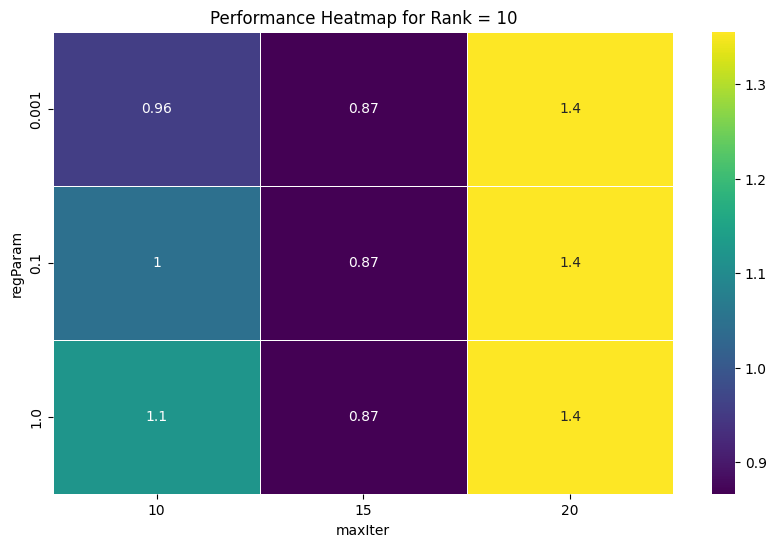

In [34]:
# Select a fixed rank and iterate over regParam and maxIter to create a heatmap
rank_index = 0  # For example, select the first rank (10)
heatmap_data = pd.DataFrame(rmse_score_array[rank_index],
                            index=param_dict['regParam'],
                            columns=param_dict['maxIter'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5)
plt.title(f'Performance Heatmap for Rank = {param_dict["rank"][rank_index]}')
plt.xlabel('maxIter')
plt.ylabel('regParam')
plt.show()

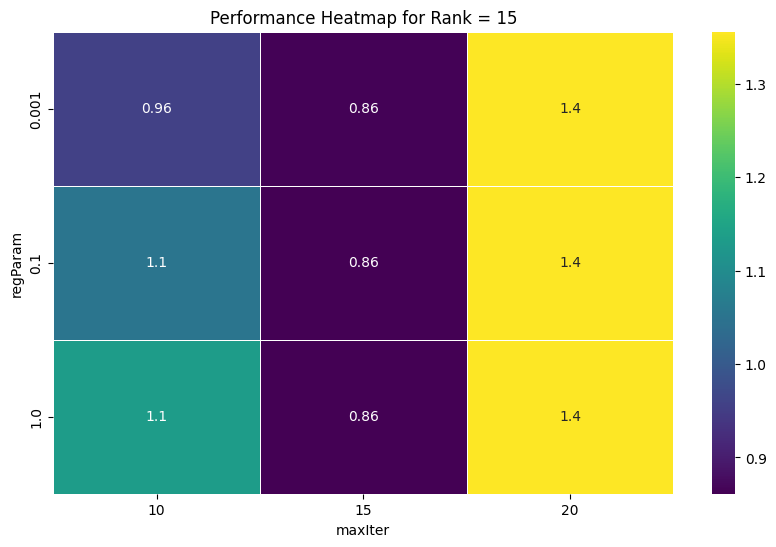

In [35]:
# Select a fixed rank and iterate over regParam and maxIter to create a heatmap
rank_index = 1  # For example, select the first rank (10)
heatmap_data = pd.DataFrame(rmse_score_array[rank_index],
                            index=param_dict['regParam'],
                            columns=param_dict['maxIter'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5)
plt.title(f'Performance Heatmap for Rank = {param_dict["rank"][rank_index]}')
plt.xlabel('maxIter')
plt.ylabel('regParam')
plt.show()

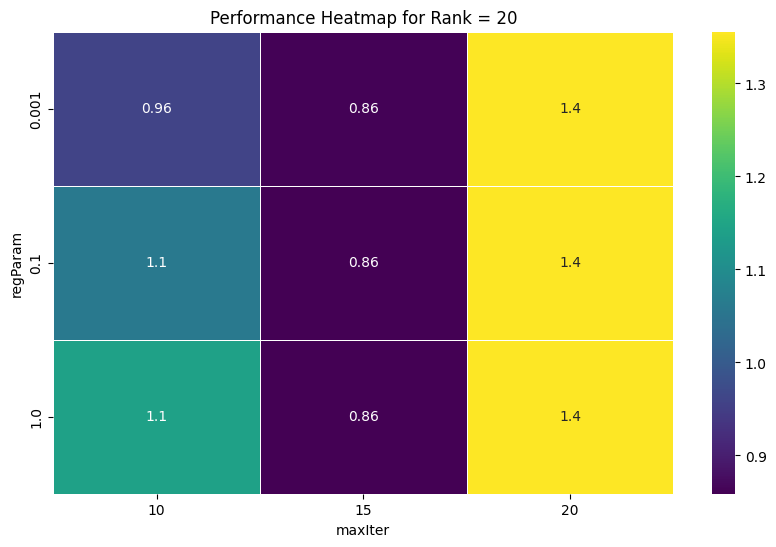

In [36]:
# Select a fixed rank and iterate over regParam and maxIter to create a heatmap
rank_index = 2  # For example, select the first rank (10)
heatmap_data = pd.DataFrame(rmse_score_array[rank_index],
                            index=param_dict['regParam'],
                            columns=param_dict['maxIter'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5)
plt.title(f'Performance Heatmap for Rank = {param_dict["rank"][rank_index]}')
plt.xlabel('maxIter')
plt.ylabel('regParam')
plt.show()

In [37]:
# Find the index of the minimum value
min_value_index = np.unravel_index(np.argmin(rmse_score_array), rmse_score_array.shape)
# Extract the corresponding parameter values
optimal_rank = param_dict['rank'][min_value_index[0]]
optimal_regParam = param_dict['regParam'][min_value_index[1]]
optimal_maxIter = param_dict['maxIter'][min_value_index[2]]

optimal_params = {
    "rank": optimal_rank,
    "regParam": optimal_regParam,
    "maxIter": optimal_maxIter,

}

print(f"Best model with best rmse_score :  {rmse_score_array[min_value_index]}", optimal_params)

Best model with best rmse_score :  0.8589 {'rank': 20, 'regParam': 1.0, 'maxIter': 15}


In [38]:
als = ALS(
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop",
    **optimal_params
)

model = als.fit(dfs_train)

24/10/16 13:04:04 WARN TaskSetManager: Stage 6233 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.
24/10/16 13:04:05 WARN TaskSetManager: Stage 6234 contains a task of very large size (8248 KiB). The maximum recommended task size is 1000 KiB.


### Recommendation for all users :

In [ ]:
dfs_rec = model.recommendForAllUsers(10)
dfs_rec.show(10)



In [ ]:

users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)


dfs_rec_subset.show(10)

In [ ]:
spark.stop()